In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os

import matplotlib.pyplot as plt, matplotlib
import numpy as np, healpy as hp, h5py
from scipy import stats, special, linalg, optimize
import scipy
import tqdm

from pylab import cm

# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)

In [3]:
import warnings
warnings.filterwarnings("ignore", message="You are modifying the state of a globally registered colormap.")
warnings.filterwarnings("ignore", message="Passing parameters norm and vmin/vmax simultaneously is deprecated")
warnings.filterwarnings("ignore", message="divide by zero encountered")
warnings.filterwarnings("ignore", message="overflow encountered in exp")

In [4]:
def add_log_cbar(ax, vmin=0., vmax=1., cmap='viridis',
             orientation='vertical', ticks=[0,1], tick_labels=['0','1']):

    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    im = plt.cm.ScalarMappable(norm=norm, cmap=cmap); im.set_array([])

    tick_pos = (np.log(np.array(ticks)) - np.log(vmin))/(np.log(vmax)-np.log(vmin))
    cbar = plt.colorbar(im, cax=ax, orientation=orientation, ticks=tick_pos)

    if orientation=='vertical':
        cbar.ax.set_yticklabels(tick_labels)
    else:
        cbar.ax.set_xticklabels(tick_labels)
    #print(tick_pos, tick_labels)

    return cbar

def plothist(values, bins, density=False, count=None, **kwargs):
    if count==None:
        count=len(values)
        
    y = np.histogram(values, bins)[0].astype(float)
    if density: y /= ((bins[1:]-bins[:-1]) * count)
    
    x = np.repeat(bins,2)
    y = np.insert(np.repeat(y,2), (0,len(y)*2), (0,0))
    
    plt.plot(x,y,**kwargs)
    
def logit(p):
    return np.log(p/(1-p))
def expit(x):
    return 1/(1+np.exp(-x))

## Load in selection function

In [5]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/astrometry/StanOutput/'

In [9]:
import selectionfunctions.hammer as hammer
from selectionfunctions.source import Source
import astropy.units as units
from selectionfunctions.std_paths import data_dir

ModuleNotFoundError: No module named 'SelectionFunctionPython'

In [ ]:

M = 85; C = 1; nside=64; jmax=4; B=2.

lengthscale_m = 0.3
lengthscale_c = 1.

file_root = f"chisquare_jmax{jmax}_nside{nside}_M{M}_C{C}_lm{lengthscale_m}"
basis_options = {'needlet':'chisquare', 'j':jmax, 'B':B, 'p':1.0, 'wavelet_tol':1e-2}

nside_original = 128
resize = int((nside_original/nside)**2+0.1)

In [8]:
jmax = 4
M = 85
C = 1
lengthscale=0.3
B=2.0
nside=64
run_name = f"chisquare_jmax{jmax}_nside{nside}_M{M}_C{C}_l{lengthscale}_B{B}"
map_fname = run_name + "_scipy_results.h5"

ast_sf = hammer.hammer(map_fname=map_fname, nside=128, C=C, M=M, 
                       spherical_harmonics_directory='/data/asfe2/Projects/astrometry/SphericalHarmonics/')

Loading auxilliary data ...


KeyError: "Unable to open object (object 'a' doesn't exist)"

## Load in Data

In [30]:
_downgrade = lambda A: A.reshape(M, A.shape[0]//M, 
                                 C, A.shape[1]//C, 
                                 hp.nside2npix(nside), A.shape[2]//hp.nside2npix(nside)).sum(axis=(1,3,5))

In [31]:
box={};
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_arr_hpx128.h', 'r') as hf:
    box['n'] = np.sum(hf['n'][...].reshape(*hf['n'][...].shape[:2], -1,4), axis=3)
    box['k'] = np.sum(hf['k'][...].reshape(*hf['k'][...].shape[:2], -1,4), axis=3)
    M_bins = hf['magbins'][...]
M_bins = np.linspace(M_bins[0], M_bins[-1], M+1)
print("Mag bins:", M_bins)

box['n'] = _downgrade(box['n'])
box['k'] = _downgrade(box['k'])

Mag bins: [ 5.   5.2  5.4  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6
  7.8  8.   8.2  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4
 10.6 10.8 11.  11.2 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2
 13.4 13.6 13.8 14.  14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8 16.
 16.2 16.4 16.6 16.8 17.  17.2 17.4 17.6 17.8 18.  18.2 18.4 18.6 18.8
 19.  19.2 19.4 19.6 19.8 20.  20.2 20.4 20.6 20.8 21.  21.2 21.4 21.6
 21.8 22. ]


$$ P( k | n, p ) = \mathrm{Binomial}( k ; n, p) $$

$$ P( p | k, n ) = \frac{\mathrm{Binomial}( k ; n, p) \, \mathrm{Beta}(p | \alpha, \beta)}{\int \mathrm{d}p\, \mathrm{Binomial}( k ; n, p) \,\mathrm{Beta}(p | \alpha, \beta)} \\
= \mathrm{Beta}(p | \alpha+k, \beta+n-k)$$

$$ \mathbb{E}[p] = (\alpha + k)/(\alpha + \beta + n) $$

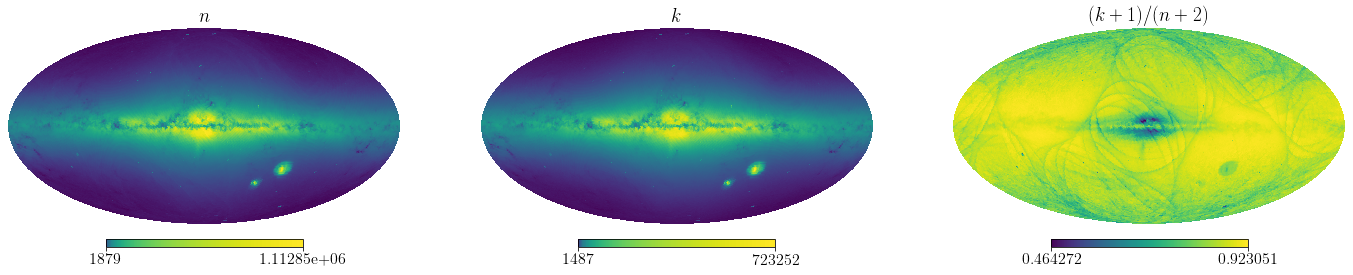

In [7]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(24,5))

minmax = np.min(np.sum(box['n'], axis=(0,1))), np.max(np.sum(box['n'], axis=(0,1)))

plt.sca(axes[0])
hp.mollview(np.sum(box['n'], axis=(0,1)), nest=True, notext=True, norm='log',# min=minmax[0], max=minmax[1],
            coord=['C','G'], title=r'$n$', cmap='viridis', hold=True, cbar=True, xsize=2000)

plt.sca(axes[1])
hp.mollview(np.sum(box['k'], axis=(0,1)), nest=True, notext=True, norm='log',#min=minmax[0], max=minmax[1],
            coord=['C','G'], title=r'$k$', cmap='viridis', hold=True, cbar=True, xsize=2000)

plt.sca(axes[2])
hp.mollview((np.sum(box['k'], axis=(0,1))+1)/(np.sum(box['n'], axis=(0,1))+2), nest=True, notext=True, norm='log',
            coord=['C','G'], title=r'$(k+1)/(n+2)$', cmap='viridis', hold=True, cbar=True, xsize=2000)

## Evaluate Selection Function

$$ x = \sum_{l=0}^{l_\mathrm{max}} \, \sum_{m=-l}^{l} a_{lm} \,Y_{lm} $$

$$ p = \mathrm{expit}(x) $$

In [15]:
g = [16.1,18.1,20.1]
prob_selection = np.zeros((3,hp.nside2npix(64)))
for i in range(3):
    ra, dec = hp.pix2ang(64,np.arange(hp.nside2npix(64)),nest=True, lonlat=True)
    coords = Source(ra*units.deg, dec*units.deg, frame='icrs', photometry={'gaia_g':g[i]*np.ones(ra.shape)})

    prob_selection[i] = ast_sf(coords, chunksize=1000)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

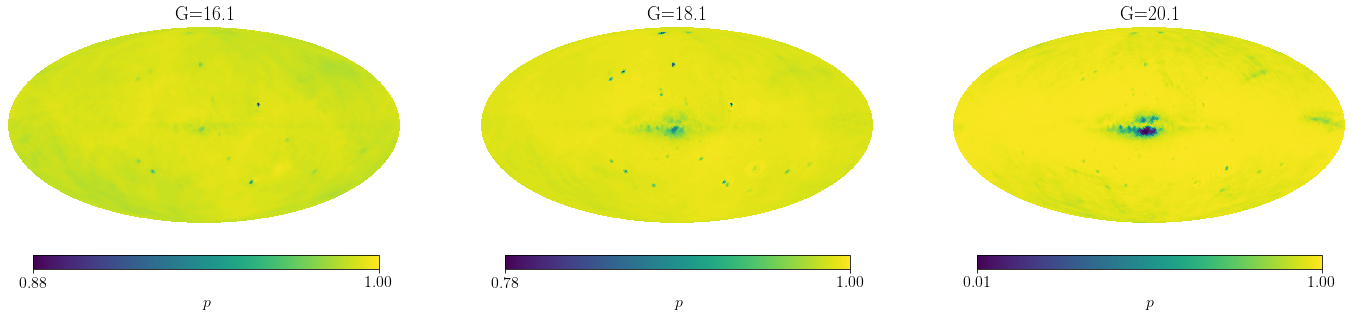

In [16]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(24,5))
for i in range(3):
    plt.sca(axes[i])
    minmax = [np.round(np.min(prob_selection[i]), decimals=2), np.round(np.max(prob_selection[i]), decimals=2)]
    hp.mollview(prob_selection[i], nest=True, min=minmax[0], max=minmax[1], cbar=False, notext=True,
                coord=['C','G'], title='G=%.1f'%g[i], cmap='viridis', hold=True, unit=r'$p$', xsize=2000)
    
    ax = fig.add_axes([i*0.273+0.14, 0.1, 0.2, 0.04]); 
    norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
    im = plt.cm.ScalarMappable(norm=norm, cmap='viridis'); im.set_array([])
    cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], minmax[1]])
    cbar.set_label(r'$p$', fontsize=16)
    
#plt.savefig('figs/%s_p_3hpx.png' % run_name, bbox_inches='tight', dpi=200)

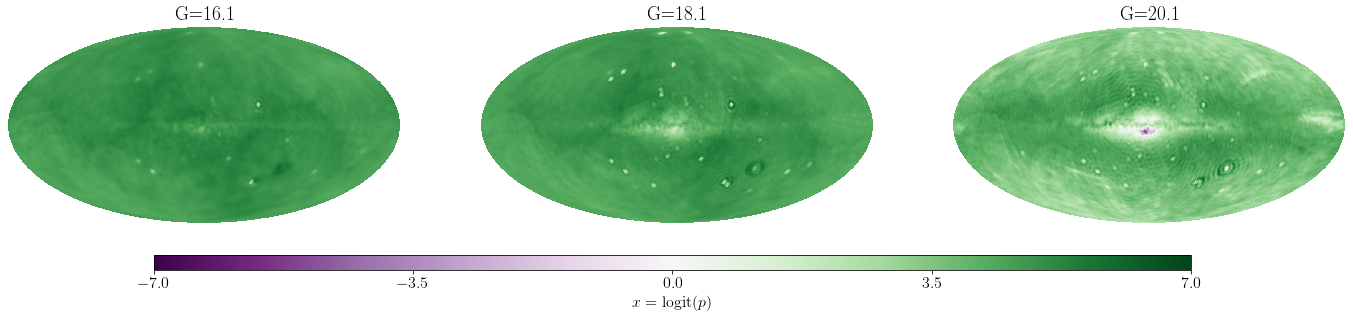

In [19]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(24,5))
minmax=[-7,7]
for i in range(3):
    plt.sca(axes[i])
    hp.mollview(logit(prob_selection[i]), nest=True, min=minmax[0],max=minmax[1], notext=True,
                coord=['C','G'], title='G=%.1f'%g[i], cmap='PRGn', hold=True, cbar=False, xsize=2000)

ax = fig.add_axes([0.21, 0.1, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], minmax[0]/2, 0., minmax[1]/2, minmax[1]])
cbar.set_label(r'$x = \mathrm{logit}(p)$', fontsize=16)

#plt.savefig('figs/%s_x_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

# Beta distribution tests of Comparison

In [10]:
g = [16.1,18.1,20.1]

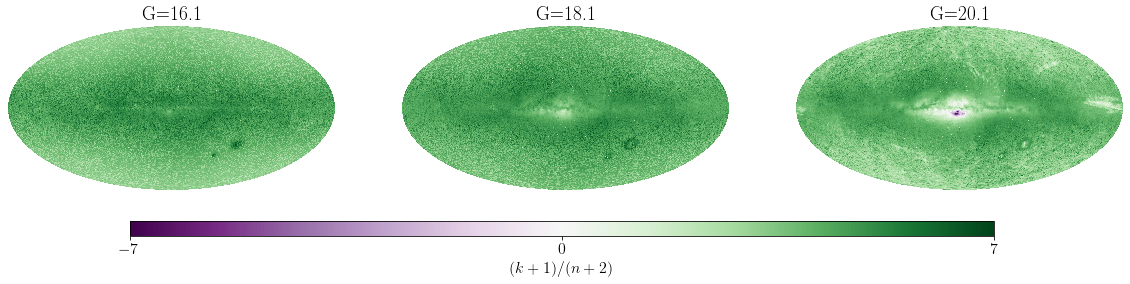

In [381]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[-7,7]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    expected = (box['k'][g_idx,0]+1)/(box['n'][g_idx,0]+2)
    hp.mollview(logit(expected), nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='PRGn', hold=True, cbar=False, xsize=2000)
#     print()

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], 0., minmax[1]])
cbar.set_label(r'$(k+1)/(n+2)$', fontsize=16)

plt.savefig('figs/%s_expected-x_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

# Load in full pixel selection function

In [22]:
sf_box = {}
with h5py.File(os.path.join(data_dir(),map_fname), 'r') as f:
    sf_box['x'] = f['x'][...]

## P-value of k

$$ p_\mathrm{value} \sim U[I_{k-1}, I_k]$$

$$ I_k = \sum_{j=0}^{k} \mathrm{Binomial}(\,j\,;\, n,\,p) $$

In [28]:
g = [16.1,18.5,20.9]

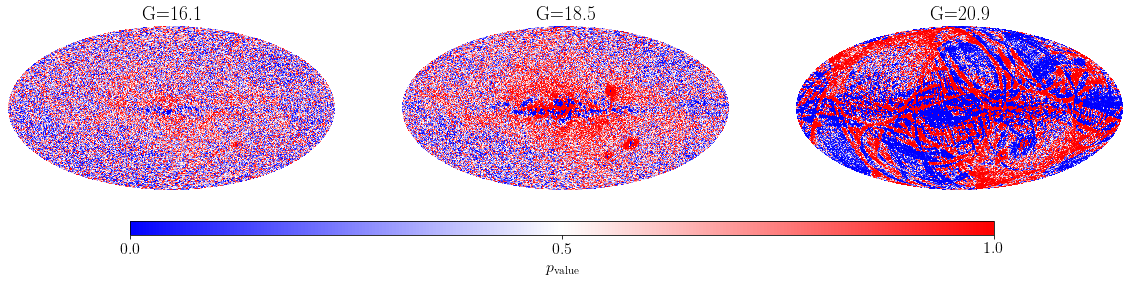

In [32]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[0.,1.]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    pval_k = scipy.stats.binom.cdf(box['k'][g_idx,0], box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pval_km1 = scipy.stats.binom.cdf(box['k'][g_idx,0]-1, box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pvals = np.random.rand(len(pval_k))*(pval_k - pval_km1) + pval_km1
    
    hp.mollview(pvals, nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='bwr', hold=True, cbar=False, xsize=2000)

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='bwr'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], 0.5, minmax[1]])
cbar.set_label(r'$p_\mathrm{value}$', fontsize=16)

#plt.savefig('figs/%s_binompval_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

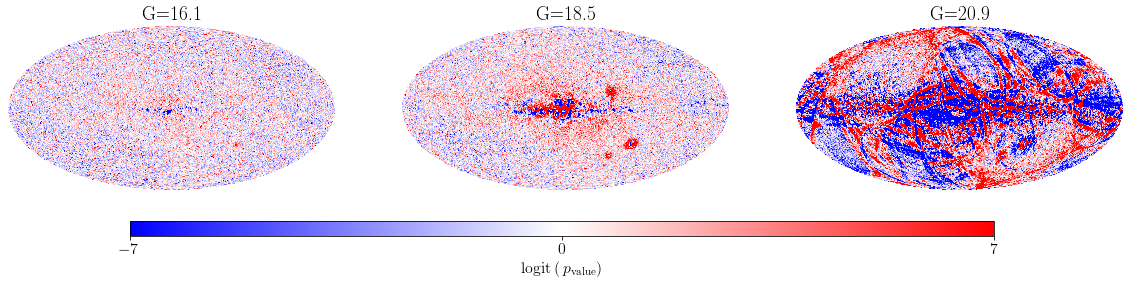

In [33]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[-7,7]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    pval_k = scipy.stats.binom.cdf(box['k'][g_idx,0], box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pval_km1 = scipy.stats.binom.cdf(box['k'][g_idx,0]-1, box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pvals = np.random.rand(len(pval_k))*(pval_k - pval_km1) + pval_km1
    
    hp.mollview(logit(pvals), nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='bwr', hold=True, cbar=False, xsize=2000)
#     print()

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='bwr'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], 0., minmax[1]])
cbar.set_label(r'$\mathrm{logit}\left(\,p_\mathrm{value}\right)$', fontsize=16)

#plt.savefig('figs/%s_logit-binompval_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

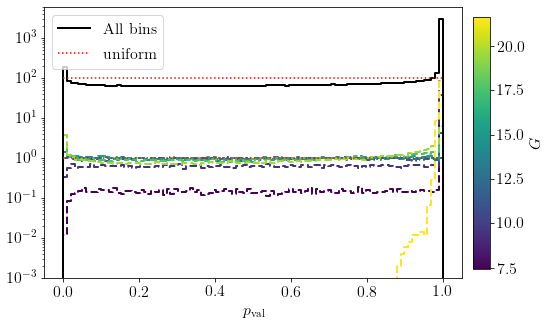

In [34]:
g = np.arange(7.5,21.6,2.)

#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig = plt.figure(figsize=(8,5))

cmap = cm.viridis; mmin=np.min(g)-0.1; mmax=np.max(g)+0.1

for i in range(len(g)):
    g_idx = np.sum(M_bins<g[i])-1
    pval_k = scipy.stats.binom.cdf(box['k'][g_idx,0], box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pval_km1 = scipy.stats.binom.cdf(box['k'][g_idx,0]-1, box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pvals = np.random.rand(len(pval_k))*(pval_k - pval_km1) + pval_km1
    plothist(pvals, bins=np.linspace(0,1,100), density=True,
            color=cmap((g[i]-mmin)/(mmax-mmin)), linewidth=2, linestyle='--')
    

pval_k = scipy.stats.binom.cdf(box['k'], box['n'], expit(sf_box['x']))
pval_km1 = scipy.stats.binom.cdf(box['k']-1, box['n'], expit(sf_box['x']))
pvals = np.random.rand(*pval_k.shape)*(pval_k - pval_km1) + pval_km1
plothist(pvals.flatten(), bins=np.linspace(0,1,100), label='All bins', 
        color='k', linewidth=2, density=True, count=len(pvals.flatten())/100)

plt.yscale('log')
plt.xlabel(r'$p_\mathrm{val}$', fontsize=16)


plt.plot([0,1], [1,1], ':r', label='uniform')
plt.plot([0,1], [100,100], ':r')
#plt.plot(x, scipy.stats.logistic.pdf(x)*10, '--r')

plt.legend(loc='upper left')

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=16)

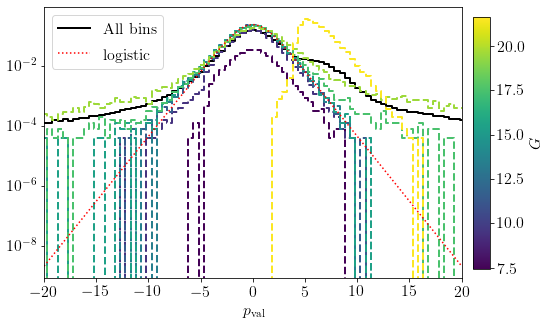

In [35]:
g = np.arange(7.5,21.6,2.)

#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig = plt.figure(figsize=(8,5))

cmap = cm.viridis; mmin=np.min(g)-0.1; mmax=np.max(g)+0.1

pval_k = scipy.stats.binom.cdf(box['k'], box['n'], expit(sf_box['x']))
pval_km1 = scipy.stats.binom.cdf(box['k']-1, box['n'], expit(sf_box['x']))
pvals = np.random.rand(*pval_k.shape)*(pval_k - pval_km1) + pval_km1
minmax = np.round(np.min(logit(pvals)[~np.isinf(logit(pvals))]), decimals=1)-1.,\
         np.round(np.max(logit(pvals)[~np.isinf(logit(pvals))]), decimals=1)+1.
bins = np.arange(minmax[0], minmax[1]+1e-10, 0.5)
    
pvals[pvals==0.] = expit(minmax[0]+0.05); pvals[pvals==1.] = expit(minmax[1]-0.05)
plothist(logit(pvals.flatten()), bins=bins, label='All bins',
        color='k', linewidth=2, density=True, count=len(pvals.flatten()))

for i in range(len(g)):
    g_idx = np.sum(M_bins<g[i])-1
    pval_k = scipy.stats.binom.cdf(box['k'][g_idx,0], box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pval_km1 = scipy.stats.binom.cdf(box['k'][g_idx,0]-1, box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pvals = np.random.rand(len(pval_k))*(pval_k - pval_km1) + pval_km1
    pvals[logit(pvals)<minmax[0]] = expit(minmax[0]+0.05); 
    pvals[logit(pvals)>minmax[1]] = expit(minmax[1]-0.05)
    plothist(logit(pvals), bins=bins,
        color=cmap((g[i]-mmin)/(mmax-mmin)), linewidth=2, linestyle='--', density=True)

plt.yscale('log')
plt.xlabel(r'$p_\mathrm{val}$', fontsize=16)

plt.xlim(-20,20)

x = np.linspace(-20,20,100)
plt.plot(x, scipy.stats.logistic.pdf(x), ':r', label='logistic')
#plt.plot(x, scipy.stats.logistic.pdf(x)*10, '--r')

plt.legend(loc='upper left')

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=16)

plt.savefig('figs/%s_binompval_logithist.png' % run_name, bbox_inches='tight', dpi=100, facecolor='w', transparent=False)